In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'

!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/dreamquark-ai/tabnet.git (to revision develop) to /tmp/pip-install-3lw1rgh7/pytorch-tabnet_392d877af82940a78d6c8f9ce96b73de
  Running command git clone --filter=blob:none --quiet https://github.com/dreamquark-ai/tabnet.git /tmp/pip-install-3lw1rgh7/pytorch-tabnet_392d877af82940a78d6c8f9ce96b73de
  Resolved https://github.com/dreamquark-ai/tabnet.git to commit d44f3b54d415741925c9c543f9a10c636ba3290a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━

In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import torch
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/머신러닝1/조별활동/와인품질분류/data

/content/drive/MyDrive/Colab Notebooks/머신러닝1/조별활동/와인품질분류/data


In [ ]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,Set
index,,,,,,,,,,,,,,
0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,1,train
1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,0,valid
2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,1,train
3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,1,train
4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,5,7.7,0.150,0.29,1.3,0.029,10.0,64.0,0.99320,3.35,0.39,10.1,1,train
5493,6,6.3,0.180,0.36,1.2,0.034,26.0,111.0,0.99074,3.16,0.51,11.0,1,train
5494,7,7.8,0.150,0.34,1.1,0.035,31.0,93.0,0.99096,3.07,0.72,11.3,1,train


In [ ]:
train['quality'].value_counts()

# 3 4 5 6 7 8 9

9       5
3      26
8     152
4     186
7     924
5    1788
6    2416
Name: quality, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(train['type'])
train['type'] = enc.transform(train['type'])
test['type'] = enc.transform(test['type'])

In [ ]:
features = [ col for col in train.columns ]

In [ ]:
train_x = train.drop('quality', axis=1)
train_y = train[['quality']]
test_x = test

In [ ]:
np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index

In [ ]:
features = [col for col in train_x.columns] 

In [ ]:
X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x[features].values

In [ ]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', 
                                lambda_sparse=0, 
                       
                      )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
save_history = []

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=1000 , patience=2,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=1,
    drop_last=False,
)

print()

save_history.append(clf.history["val_accuracy"])



epoch 0  | loss: 1.83349 | train_accuracy: 0.43937 | val_accuracy: 0.43184 |  0:00:00s
epoch 1  | loss: 1.53737 | train_accuracy: 0.44074 | val_accuracy: 0.42635 |  0:00:01s
epoch 2  | loss: 1.34812 | train_accuracy: 0.43915 | val_accuracy: 0.42269 |  0:00:02s

Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_accuracy = 0.43184



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


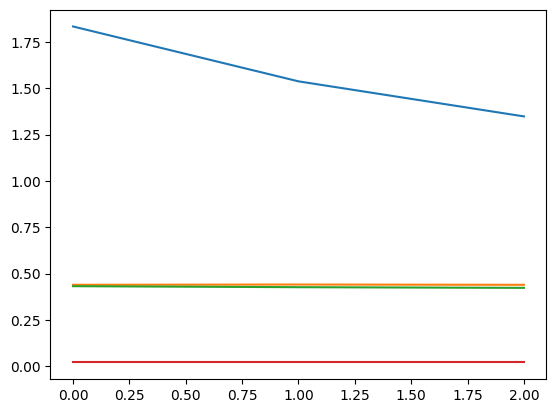

In [ ]:
# plot losses
plt.plot(clf.history['loss'])

# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['val_accuracy'])

# plot learning rates
plt.plot(clf.history['lr'])

In [ ]:
preds = clf.predict_proba(X_test)

In [ ]:
preds

[array([[3.14205158e-06, 1.23007119e-26, 4.16687796e-14, ...,
         7.65355210e-08, 1.61811821e-13, 1.14076334e-18],
        [2.87973089e-03, 4.43676563e-13, 3.71968838e-07, ...,
         3.85391177e-04, 1.08075471e-06, 2.22765073e-09],
        [2.52448353e-05, 2.28328582e-22, 6.68519060e-12, ...,
         1.13923716e-06, 2.05948210e-11, 1.03536310e-15],
        ...,
        [3.04720652e-05, 5.56882889e-22, 1.06014286e-11, ...,
         1.45572051e-06, 3.19235714e-11, 1.92226822e-15],
        [6.13176417e-06, 2.86392402e-25, 2.11705328e-13, ...,
         1.81678502e-07, 7.65486741e-13, 1.00883196e-17],
        [3.80605161e-06, 3.03210953e-26, 6.63926921e-14, ...,
         9.80534978e-08, 2.52646157e-13, 2.13046074e-18]], dtype=float32)]

In [ ]:
print(int(1.23007119e-26))

0


In [ ]:
print(preds[0][0])
print(preds[0][0].argmax())

print(preds[0][1])
print(preds[0][1].argmax())


# 3 4 5 6 7 8 9



[3.1420516e-06 1.2300712e-26 4.1668780e-14 9.9999678e-01 7.6535521e-08
 1.6181182e-13 1.1407633e-18]
3
[2.8797309e-03 4.4367656e-13 3.7196884e-07 9.9673343e-01 3.8539118e-04
 1.0807547e-06 2.2276507e-09]
3


In [ ]:
a = []
for i in range(1000):
  a.append(preds[0][i].argmax())

In [ ]:
a

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [ ]:
len(preds[0])

1000

In [ ]:
submission['quality'] = a
submission['quality'] = submission['quality']+3 #3quality가 3부터 시작하므로

In [ ]:
submission

,index,quality
0,0,6
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
995,995,6
996,996,6
997,997,6
998,998,6


# 다 6인이유가 quality가 6인 클래스가 가장많아서 그런거같다.